[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Bradley-Buchner/worm_synergy/blob/master/notebooks/model_demo.ipynb)

# Model Demo
Demo for the Worm Synergy Graph Transformer model, designed to predict the likelihood that two genes determine lifespan synergistically

In [ ]:
!git clone https://github.com/Bradley-Buchner/worm_synergy.git

In [ ]:
%%bash
# pip install -qr requirements.txt

# NOTE: you may now need to restart your kernel

In [10]:
# import torch
# import numpy as np
import pickle
import importlib
from functools import partial
import networkx as nx
# import matplotlib.pyplot as plt
# from torch_geometric.utils import subgraph
# from scipy.stats import pearsonr, spearmanr

# from model import *
import model
from model.preprocessing import *
from model.models import *
from model.utils import *
# from model.train import *

importlib.reload(model.preprocessing)
importlib.reload(model.models)
importlib.reload(model.utils)
# importlib.reload(model.train)


<module 'model.utils' from '/Users/bradleybuchner/Desktop/grad_school/research/aging_project/worm_synergy/model/utils.py'>

In [3]:
data = torch.load('../data/worm_synergy_pyg_data_demo_raw.pt', weights_only=False)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
data.to(device)

with open("../data/perturbation2idx.pkl", "rb") as f:
    perturbation2idx = pickle.load(f)

with open("../data/node2id.pkl", 'rb') as f:
    node2id = pickle.load(f)

with open("../data/id2node.pkl", 'rb') as f:
    id2node = pickle.load(f)

In [4]:
uninformative_prior = torch.tensor([1.0, 1.0, 1.0]).to("mps")
# print(uninformative_prior)
data_processed = process_data_to_soft_smoothed_label_dist(data, prior=uninformative_prior, effect_type_key='pair_effect_type_index', pair_index_key='pair_index', pair_pert_index_key='pair_pert_index')
print(data_processed)

Data(x=[11493, 11493], edge_index=[2, 90364], node_index=[11493], edge_type=[90364], x_embed_go=[11493, 4], x_embed_disease=[11493, 4], x_embed_anatomy=[11493, 4], x_embed_phenotype_comb=[11493, 4], x_embed_development=[11493, 4], x_embed_pt5=[11493, 1024], x_embed_pt5_pca=[11493, 4], pair_effect=[1431], lifespan_association=[11493], lifespan_dist=[11493], name='data_effect_type', pair_pert_group_index=[4, 802], pair_effect_type_soft=[802, 3], pair_effect_type_soft_smoothed=[802, 3], pair_obs_counts=[802, 3], pair_obs_total_counts=[802])


### Summarize genetic interaction network from WormBase

In [5]:
# --- 3. Find the Maximum Degree ---
print("=== Genetic Interaction Network Summary ===")
out_degree = degree(data_processed.edge_index[0], num_nodes=data_processed.num_nodes)
in_degree = degree(data_processed.edge_index[1], num_nodes=data_processed.num_nodes)
avg_degree = torch.median(torch.cat([in_degree, out_degree], dim=0)).item()
max_degree = torch.max(torch.cat([in_degree, out_degree], dim=0)).item()

print(f"Total number of nodes: {data.num_nodes}")
print(f"Total number of edges: {data.num_edges}")
print(f"Median node degree: {avg_degree:.0f}")
print(f"Maximum node degree: {max_degree:.0f}")
print(f"Types of interactions/edges: {data.edge_type.max().item() + 1} (genetic, physical, and regulatory)")
print("Directed? => TRUE")

=== Genetic Interaction Network Summary ===
Total number of nodes: 11493
Total number of edges: 90364
Median node degree: 2
Maximum node degree: 1737
Types of interactions/edges: 3 (genetic, physical, and regulatory)
Directed? => TRUE


### Summarize experimental data from SynergyAge

In [6]:
print("=== SynergyAge Data Summary ===")
print(f"Number of unique gene pairs: {data_processed.pair_obs_total_counts.shape[0]}")
print(f"Avg. number of experiments for each gene pair: {data_processed.pair_obs_total_counts.mean():.2f}")

sorted_counts, sorted_indices = data_processed.pair_obs_total_counts.sort(descending=True)
top_k = 5
print(f"\n=== Top {top_k} Gene Pairs by Experiment Count ===")
for i in range(top_k):
    idx = sorted_indices[i]
    count = sorted_counts[i].item()
    gene_id_1 = data_processed.pair_pert_group_index[0, idx].item()
    gene_id_2 = data_processed.pair_pert_group_index[2, idx].item()
    gene_name_1 = id2node[gene_id_1]
    gene_name_2 = id2node[gene_id_2]
    print(f"Rank {i+1}: Genes: ({gene_name_1}, {gene_name_2}) - Count: {int(count)}")

# --- Global Averages ---
# Calculate mean across all pairs
avg_effects = data_processed.pair_effect_type_soft.mean(dim=0)
print("\n=== Average of Interaction Type Frequencies ===")
print(f"Avg. Antagonistic fraction: {avg_effects[0].item():.1%}")
print(f"Avg. Neither fraction:      {avg_effects[1].item():.1%}")
print(f"Avg. Synergistic fraction:  {avg_effects[2].item():.1%}")

avg_effects_smoothed = data_processed.pair_effect_type_soft_smoothed.mean(dim=0)
print("\nAfter Bayesian Smoothing with Uninformative Prior (pseudocounts of 1 for each):")
print(f"Avg. Antagonistic fraction: {avg_effects_smoothed[0].item():.1%}")
print(f"Avg. Neither fraction:      {avg_effects_smoothed[1].item():.1%}")
print(f"Avg. Synergistic fraction:  {avg_effects_smoothed[2].item():.1%}")

# --- Top Pairs ---
sorted_counts, sorted_indices = data_processed.pair_obs_total_counts.sort(descending=True)
top_k = 5

print(f"\n=== Top {top_k} Gene Pairs by Experiment Count ===")

for i in range(top_k):
    idx = sorted_indices[i]
    count = sorted_counts[i].item()
    gene_id_1 = data_processed.pair_pert_group_index[0, idx].item()
    gene_id_2 = data_processed.pair_pert_group_index[2, idx].item()
    gene_name_1 = id2node[gene_id_1]
    gene_name_2 = id2node[gene_id_2]
    effects = data_processed.pair_effect_type_soft[idx]

    print(f"Rank {i+1}: ({gene_name_1}, {gene_name_2}) | Count: {int(count)}")
    print(f"    Breakdown: Antag={effects[0]:.1%}, Neither={effects[1]:.1%}, Syn={effects[2]:.1%}")

=== SynergyAge Data Summary ===
Number of unique gene pairs: 802
Avg. number of experiments for each gene pair: 1.78

=== Top 5 Gene Pairs by Experiment Count ===
Rank 1: Genes: (daf-2, skn-1) - Count: 23
Rank 2: Genes: (vhl-1, hif-1) - Count: 18
Rank 3: Genes: (daf-16, hif-1) - Count: 15
Rank 4: Genes: (daf-2, rsks-1) - Count: 14
Rank 5: Genes: (sir-2.1, hcf-1) - Count: 14

=== Average of Interaction Type Frequencies ===
Avg. Antagonistic fraction: 4.9%
Avg. Neither fraction:      74.4%
Avg. Synergistic fraction:  20.7%

After Bayesian Smoothing with Uninformative Prior (pseudocounts of 1 for each):
Avg. Antagonistic fraction: 24.0%
Avg. Neither fraction:      47.2%
Avg. Synergistic fraction:  28.8%

=== Top 5 Gene Pairs by Experiment Count ===
Rank 1: (daf-2, skn-1) | Count: 23
    Breakdown: Antag=0.0%, Neither=95.7%, Syn=4.3%
Rank 2: (vhl-1, hif-1) | Count: 18
    Breakdown: Antag=22.2%, Neither=77.8%, Syn=0.0%
Rank 3: (daf-16, hif-1) | Count: 15
    Breakdown: Antag=0.0%, Neither=

### Build gene-pair subgraphs for the transformer model

In [7]:
# --- Build k-hop subgraphs ---
spd_filepath = "../data/graph_transformer/spd_matrix.pt"
spd_tensor = torch.load(spd_filepath, weights_only=False)

configs = {
    'max_spd': spd_tensor.max().item(),
    'max_dist_uv': spd_tensor.max().item(),
    'k_hop': 1,
    'sampling_mode': 'union',
    'target_subgraph_size': 0,
    'max_in_degree': max_degree,
    'max_out_degree': max_degree,
    'num_degree_bins': 4,
    'attributes_dir': '../data/graph_transformer',
    'output_path': None,
    'device': 'cpu'
}

subgraph_data = preprocess_and_save_subgraphs_graphormer(
    data=data_processed,
    configs=configs
)

--- Starting Subgraph Pre-processing ---
Mode: union, Target Augmentation Size: 0, Device: cpu
Loading pre-computed attributes from ../data/graph_transformer...

Processing 802 pairs...
Target soft/smoothed data found.


Building Subgraphs: 100%|██████████| 802/802 [00:02<00:00, 338.98it/s]

--- Pre-processing finished successfully! Returning 802 samples. ---


### Prepare subgraph data for model training

In [11]:
# --- Make train/test split ---
train_list, test_list = train_test_split_simple(subgraph_data, train_frac=0.8, seed=23)
print(f"# of training samples (gene pairs): {len(train_list)}")
print(f"# of test samples (gene pairs): {len(test_list)}")
train_pairs = [pair_data.get('pair') for pair_data in train_list]
test_pairs = [pair_data.get('pair') for pair_data in test_list]
if not set(train_pairs).isdisjoint(set(test_pairs)):
    print("Warning: LEAKAGE... Training pair found in test set.") # This will run
else:
    print("No leakage detected between training and test sets. Good to go!")

# of training samples (gene pairs): 641
# of test samples (gene pairs): 161
No leakage detected between training and test sets. Good to go!


### Inspect model training data (gene-pair subgraphs)

In [12]:
# Summary of subgraph data
train_dataset = PairSubgraphDataset(train_list)
test_dataset = PairSubgraphDataset(test_list)

subgraph_size = []
max_dists_to_u_or_v = []
for sample in train_dataset:
    N_subgraph = len(sample['node_ids'])
    subgraph_size.append(N_subgraph)
    max_dist_to_u = sample['dist_to_u'].max().item()
    max_dist_to_v = sample['dist_to_v'].max().item()
    max_to_u_or_v = max(max_dist_to_u, max_dist_to_v)
    max_dists_to_u_or_v.append(max_to_u_or_v)

print("=== Subgraph Data Summary (Training Set) ===")
print(f"Mean subgraph size: {np.mean(subgraph_size):.0f}")
print(f"Median subgraph size: {np.median(subgraph_size):.0f}")
print(f"Max subgraph size: {np.max(subgraph_size)}")
print(f"Min subgraph size: {np.min(subgraph_size)}")
print(f"Furthest dist from u or v: {np.max(max_dists_to_u_or_v)}")

=== Subgraph Data Summary (Training Set) ===
Mean subgraph size: 141
Median subgraph size: 182
Max subgraph size: 515
Min subgraph size: 3
Furthest dist from u or v: 6


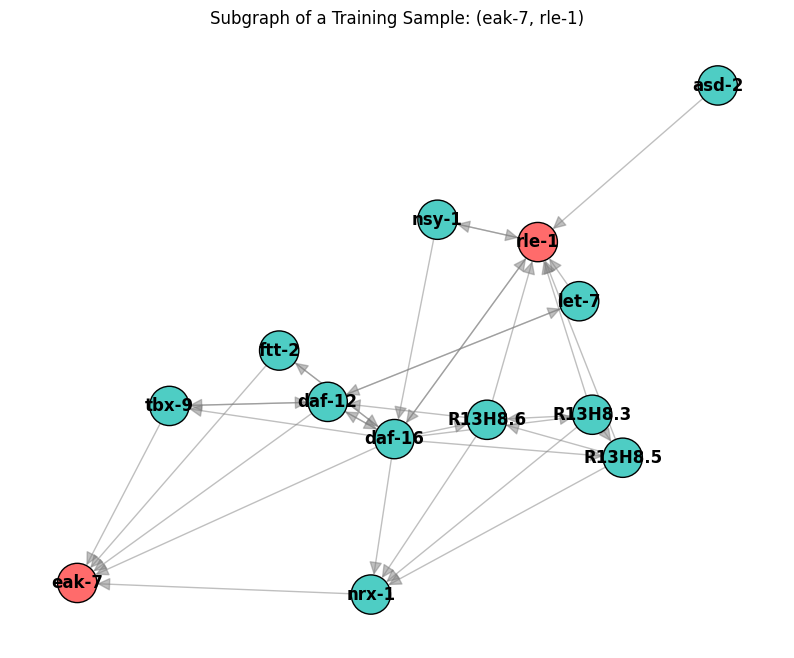

In [13]:
sample = train_dataset[1]
subset_nodes = sample['node_ids']
focal_pair = sample['pair']

edge_index_sub, _ = subgraph(
    subset_nodes,
    data_processed.edge_index,
    relabel_nodes=False
)

G = nx.DiGraph()
G.add_nodes_from(subset_nodes.tolist())
G.add_edges_from(edge_index_sub.t().tolist())

node_colors = []
for node in G.nodes():
    if node in focal_pair.tolist():
        node_colors.append('#ff6b6b')
    else:
        node_colors.append('#4ecdc4')

node_labels = {node: id2node.get(node, node) for node in G.nodes()}
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, seed=42)

nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=800, edgecolors='black')
nx.draw_networkx_edges(G, pos, edge_color='gray', alpha=0.5, arrows=True, arrowstyle='-|>',  arrowsize=20, node_size=800)
nx.draw_networkx_labels(G, pos, labels=node_labels, font_color='black', font_weight='bold')
# nx.draw_networkx_labels(G, pos, font_color='black', font_weight='bold')

focal_pair_label = f"({id2node[focal_pair[0].item()]}, {id2node[focal_pair[1].item()]})"
plt.title(f"Subgraph of a Training Sample: {focal_pair_label}")
plt.axis('off')
plt.show()

## Train a model

In [14]:
pert_a_max = data_processed.pair_pert_group_index[1].max().item()
pert_b_max = data_processed.pair_pert_group_index[3].max().item()
pert_padding = max(pert_a_max, pert_b_max) + 1

collate_fn_padding = {
    'node_ids': data.num_nodes,
    'node_perturbations': pert_padding,
    'in_degree': max_degree + 1,
    'out_degree': max_degree + 1,
    'dist_to_u': spd_tensor.max().item() + 1,
    'dist_to_v': spd_tensor.max().item() + 1,
    'pairwise_dist': spd_tensor.max().item() + 1,
    'adj_matrix': data_processed.edge_type.max().item() + 1,
    'average_edge_type_encoding': data_processed.edge_type.max().item() + 1,
    'lifespan_dist': data_processed.lifespan_dist.max().item() + 1
}

graphormer_collate = partial(graphormer_collate_fn, pad_values=collate_fn_padding)

train_dataset = PairSubgraphDataset(train_list)
test_dataset = PairSubgraphDataset(test_list)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=graphormer_collate)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=graphormer_collate)

In [15]:
num_epochs = 70
C = 3

params = {
    'sum_node_features': True,
    'use_pretrained_gene_embs': False,
    'fine_tune_gene_emb': False,
    'fine_tune_ont_emb': False,
    'randomize_labels': False,
    'max_spd': spd_tensor.max().item(),
    'num_degree_bins': 4,
    'dropout_p': 0.1,
    'd_model': 8,
    'num_heads': 2,
    'num_layers': 6
}

model = RelationalPairClassifierGraphormer(
    graph_data = data_processed,
    params = params
).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
                optimizer, T_0=10, T_mult=2, eta_min=0.0
            )
loss_fn = nn.KLDivLoss(reduction='batchmean')

In [31]:
# Run this cell only if you want to train from scratch. This will take about 5 mins.
# If not, skip to the next cell and load a pre-trained model.

training_results, test_preds = train_synergy_model(model, train_loader, test_loader, label_name='target_soft_smoothed', optimizer=optimizer, scheduler=scheduler, loss_fn=loss_fn, device=device, randomize_labels=params.get('randomize_labels'), num_epochs=num_epochs, num_classes=C)

Epoch 001


Eval: 100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


lr=0.0009755282581475768  train_loss=0.0955  test_loss=0.0757

Epoch 002


Eval: 100%|██████████| 6/6 [00:00<00:00, 14.04it/s]


lr=0.0009045084971874737  train_loss=0.0638  test_loss=0.0671

Epoch 003


Eval: 100%|██████████| 6/6 [00:00<00:00, 14.33it/s]


lr=0.0007938926261462366  train_loss=0.0592  test_loss=0.0642

Epoch 004


Eval: 100%|██████████| 6/6 [00:00<00:00, 13.66it/s]


lr=0.0006545084971874737  train_loss=0.0586  test_loss=0.0640

Epoch 005


Eval: 100%|██████████| 6/6 [00:00<00:00, 13.75it/s]


lr=0.0005  train_loss=0.0594  test_loss=0.0638

Epoch 006


Eval: 100%|██████████| 6/6 [00:00<00:00, 14.86it/s]


lr=0.00034549150281252633  train_loss=0.0591  test_loss=0.0639

Epoch 007


Eval: 100%|██████████| 6/6 [00:00<00:00, 14.14it/s]


lr=0.00020610737385376348  train_loss=0.0588  test_loss=0.0638

Epoch 008


Eval: 100%|██████████| 6/6 [00:00<00:00, 14.85it/s]


lr=9.549150281252633e-05  train_loss=0.0575  test_loss=0.0636

Epoch 009


Eval: 100%|██████████| 6/6 [00:00<00:00, 14.72it/s]


lr=2.4471741852423235e-05  train_loss=0.0576  test_loss=0.0635

Epoch 010


Eval: 100%|██████████| 6/6 [00:00<00:00, 14.73it/s]


lr=0.001  train_loss=0.0584  test_loss=0.0635

Epoch 011


Eval: 100%|██████████| 6/6 [00:00<00:00, 12.26it/s]


lr=0.0009938441702975688  train_loss=0.0573  test_loss=0.0634

Epoch 012


Eval: 100%|██████████| 6/6 [00:00<00:00, 13.27it/s]


lr=0.0009755282581475768  train_loss=0.0573  test_loss=0.0630

Epoch 013


Eval: 100%|██████████| 6/6 [00:00<00:00, 13.07it/s]


lr=0.0009455032620941839  train_loss=0.0569  test_loss=0.0631

Epoch 014


Eval: 100%|██████████| 6/6 [00:00<00:00, 12.57it/s]


lr=0.0009045084971874737  train_loss=0.0568  test_loss=0.0628

Epoch 015


Eval: 100%|██████████| 6/6 [00:00<00:00, 12.51it/s]


lr=0.0008535533905932737  train_loss=0.0576  test_loss=0.0633

Epoch 016


Eval: 100%|██████████| 6/6 [00:00<00:00, 13.02it/s]


lr=0.0007938926261462366  train_loss=0.0583  test_loss=0.0626

Epoch 017


Eval: 100%|██████████| 6/6 [00:00<00:00, 13.74it/s]


lr=0.0007269952498697733  train_loss=0.0572  test_loss=0.0623

Epoch 018


Eval: 100%|██████████| 6/6 [00:00<00:00, 13.38it/s]


lr=0.0006545084971874737  train_loss=0.0567  test_loss=0.0626

Epoch 019


Eval: 100%|██████████| 6/6 [00:00<00:00, 13.97it/s]


lr=0.0005782172325201155  train_loss=0.0579  test_loss=0.0625

Epoch 020


Eval: 100%|██████████| 6/6 [00:00<00:00, 10.26it/s]


lr=0.0005  train_loss=0.0575  test_loss=0.0625

Epoch 021


Eval: 100%|██████████| 6/6 [00:00<00:00, 10.57it/s]


lr=0.0004217827674798847  train_loss=0.0568  test_loss=0.0621

Epoch 022


Eval: 100%|██████████| 6/6 [00:00<00:00, 12.80it/s]


lr=0.00034549150281252633  train_loss=0.0558  test_loss=0.0620

Epoch 023


Eval: 100%|██████████| 6/6 [00:00<00:00, 13.93it/s]


lr=0.00027300475013022663  train_loss=0.0572  test_loss=0.0624

Epoch 024


Eval: 100%|██████████| 6/6 [00:00<00:00, 13.70it/s]


lr=0.00020610737385376348  train_loss=0.0564  test_loss=0.0622

Epoch 025


Eval: 100%|██████████| 6/6 [00:00<00:00, 11.94it/s]


lr=0.00014644660940672628  train_loss=0.0564  test_loss=0.0622

Epoch 026


Eval: 100%|██████████| 6/6 [00:00<00:00, 13.73it/s]


lr=9.549150281252633e-05  train_loss=0.0563  test_loss=0.0621

Epoch 027


Eval: 100%|██████████| 6/6 [00:00<00:00, 12.77it/s]


lr=5.449673790581611e-05  train_loss=0.0563  test_loss=0.0619

Epoch 028


Eval: 100%|██████████| 6/6 [00:00<00:00, 12.97it/s]


lr=2.4471741852423235e-05  train_loss=0.0574  test_loss=0.0620

Epoch 029


Eval: 100%|██████████| 6/6 [00:00<00:00, 13.11it/s]


lr=6.15582970243117e-06  train_loss=0.0562  test_loss=0.0620

Epoch 030


Eval: 100%|██████████| 6/6 [00:00<00:00, 14.02it/s]


lr=0.001  train_loss=0.0547  test_loss=0.0620

Epoch 031


Eval: 100%|██████████| 6/6 [00:00<00:00, 13.18it/s]


lr=0.000998458666866564  train_loss=0.0561  test_loss=0.0614

Epoch 032


Eval: 100%|██████████| 6/6 [00:00<00:00, 13.35it/s]


lr=0.0009938441702975688  train_loss=0.0577  test_loss=0.0617

Epoch 033


Eval: 100%|██████████| 6/6 [00:00<00:00, 12.47it/s]


lr=0.0009861849601988384  train_loss=0.0564  test_loss=0.0618

Epoch 034


Eval: 100%|██████████| 6/6 [00:00<00:00, 12.35it/s]


lr=0.0009755282581475768  train_loss=0.0562  test_loss=0.0604

Epoch 035


Eval: 100%|██████████| 6/6 [00:00<00:00, 12.15it/s]


lr=0.0009619397662556434  train_loss=0.0560  test_loss=0.0616

Epoch 036


Eval: 100%|██████████| 6/6 [00:00<00:00, 10.13it/s]


lr=0.0009455032620941839  train_loss=0.0572  test_loss=0.0600

Epoch 037


Eval: 100%|██████████| 6/6 [00:00<00:00, 11.31it/s]


lr=0.0009263200821770461  train_loss=0.0552  test_loss=0.0596

Epoch 038


Eval: 100%|██████████| 6/6 [00:00<00:00, 11.56it/s]


lr=0.0009045084971874737  train_loss=0.0547  test_loss=0.0590

Epoch 039


Eval: 100%|██████████| 6/6 [00:00<00:00, 11.78it/s]


lr=0.0008802029828000156  train_loss=0.0537  test_loss=0.0593

Epoch 040


Eval: 100%|██████████| 6/6 [00:00<00:00, 14.16it/s]


lr=0.0008535533905932737  train_loss=0.0542  test_loss=0.0592

Epoch 041


Eval: 100%|██████████| 6/6 [00:00<00:00, 14.18it/s]


lr=0.000824724024165092  train_loss=0.0538  test_loss=0.0581

Epoch 042


Eval: 100%|██████████| 6/6 [00:00<00:00, 11.40it/s]


lr=0.0007938926261462366  train_loss=0.0529  test_loss=0.0573

Epoch 043


Eval: 100%|██████████| 6/6 [00:00<00:00, 10.76it/s]


lr=0.0007612492823579744  train_loss=0.0527  test_loss=0.0574

Epoch 044


Eval: 100%|██████████| 6/6 [00:00<00:00, 11.95it/s]


lr=0.0007269952498697733  train_loss=0.0522  test_loss=0.0568

Epoch 045


Eval: 100%|██████████| 6/6 [00:00<00:00, 11.04it/s]


lr=0.000691341716182545  train_loss=0.0521  test_loss=0.0567

Epoch 046


Eval: 100%|██████████| 6/6 [00:00<00:00, 10.80it/s]


lr=0.0006545084971874737  train_loss=0.0518  test_loss=0.0568

Epoch 047


Eval: 100%|██████████| 6/6 [00:00<00:00, 13.17it/s]


lr=0.0006167226819279528  train_loss=0.0495  test_loss=0.0551

Epoch 048


Eval: 100%|██████████| 6/6 [00:00<00:00, 12.64it/s]


lr=0.0005782172325201155  train_loss=0.0511  test_loss=0.0571

Epoch 049


Eval: 100%|██████████| 6/6 [00:00<00:00, 11.70it/s]


lr=0.0005392295478639225  train_loss=0.0495  test_loss=0.0534

Epoch 050


Eval: 100%|██████████| 6/6 [00:00<00:00, 12.08it/s]


lr=0.0005  train_loss=0.0487  test_loss=0.0534

Epoch 051


Eval: 100%|██████████| 6/6 [00:00<00:00, 12.01it/s]


lr=0.0004607704521360776  train_loss=0.0484  test_loss=0.0531

Epoch 052


Eval: 100%|██████████| 6/6 [00:00<00:00, 13.73it/s]


lr=0.0004217827674798847  train_loss=0.0481  test_loss=0.0563

Epoch 053


Eval: 100%|██████████| 6/6 [00:00<00:00, 11.66it/s]


lr=0.00038327731807204733  train_loss=0.0482  test_loss=0.0544

Epoch 054


Eval: 100%|██████████| 6/6 [00:00<00:00, 11.29it/s]


lr=0.00034549150281252633  train_loss=0.0477  test_loss=0.0542

Epoch 055


Eval: 100%|██████████| 6/6 [00:00<00:00,  9.18it/s]


lr=0.0003086582838174551  train_loss=0.0460  test_loss=0.0542

Epoch 056


Eval: 100%|██████████| 6/6 [00:00<00:00, 11.87it/s]


lr=0.00027300475013022663  train_loss=0.0474  test_loss=0.0538

Epoch 057


Eval: 100%|██████████| 6/6 [00:00<00:00, 12.33it/s]


lr=0.00023875071764202561  train_loss=0.0462  test_loss=0.0538

Epoch 058


Eval: 100%|██████████| 6/6 [00:00<00:00, 12.82it/s]


lr=0.00020610737385376348  train_loss=0.0458  test_loss=0.0534

Epoch 059


Eval: 100%|██████████| 6/6 [00:00<00:00, 12.73it/s]


lr=0.00017527597583490823  train_loss=0.0447  test_loss=0.0534

Epoch 060


Eval: 100%|██████████| 6/6 [00:00<00:00, 12.58it/s]


lr=0.00014644660940672628  train_loss=0.0457  test_loss=0.0530

Epoch 061


Eval: 100%|██████████| 6/6 [00:00<00:00, 10.87it/s]


lr=0.00011979701719998459  train_loss=0.0448  test_loss=0.0534

Epoch 062


Eval: 100%|██████████| 6/6 [00:00<00:00, 13.68it/s]


lr=9.549150281252633e-05  train_loss=0.0444  test_loss=0.0536

Epoch 063


Eval: 100%|██████████| 6/6 [00:00<00:00, 11.59it/s]


lr=7.367991782295391e-05  train_loss=0.0457  test_loss=0.0541

Epoch 064


Eval: 100%|██████████| 6/6 [00:00<00:00, 10.97it/s]


lr=5.449673790581611e-05  train_loss=0.0441  test_loss=0.0533

Epoch 065


Eval: 100%|██████████| 6/6 [00:00<00:00, 13.79it/s]


lr=3.806023374435663e-05  train_loss=0.0434  test_loss=0.0532

Epoch 066


Eval: 100%|██████████| 6/6 [00:00<00:00, 12.49it/s]


lr=2.4471741852423235e-05  train_loss=0.0435  test_loss=0.0534

Epoch 067


Eval: 100%|██████████| 6/6 [00:00<00:00, 13.99it/s]


lr=1.3815039801161721e-05  train_loss=0.0436  test_loss=0.0531

Epoch 068


Eval: 100%|██████████| 6/6 [00:00<00:00, 12.82it/s]


lr=6.15582970243117e-06  train_loss=0.0438  test_loss=0.0530

Epoch 069


Eval: 100%|██████████| 6/6 [00:00<00:00, 11.46it/s]


lr=1.541333133436018e-06  train_loss=0.0428  test_loss=0.0530

Epoch 070


Eval: 100%|██████████| 6/6 [00:00<00:00,  8.69it/s]


lr=0.001  train_loss=0.0436  test_loss=0.0530

Training complete!


Eval: 100%|██████████| 6/6 [00:00<00:00, 11.73it/s]


In [44]:
# # Save the model
# save_path = '../data/demo_model.pth'
# torch.save({
#     "state_dict": model.state_dict(),
#     "history": model.history
# }, save_path)
# print(f"Model state and history saved to: {save_path}")

Model state and history saved to: ../data/demo_model.pth


In [16]:
saved_model = torch.load('../data/demo_model.pth', map_location=device, weights_only=False)
model_loaded = RelationalPairClassifierGraphormer(
    graph_data=data_processed,
    params=params
).to(device)
model_loaded.load_state_dict(saved_model["state_dict"])
model_loaded.history = saved_model.get("history", {})   # safe fallback
# model_loaded.eval()

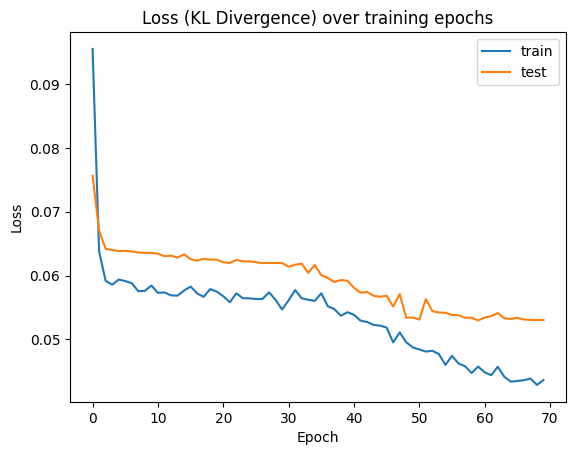

In [17]:
# --- Plot training history ---
plt.plot(model_loaded.history['train_loss'], label="train")
plt.plot(model_loaded.history['test_loss'], label="test")
plt.title("Loss (KL Divergence) over training epochs")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Summarize model performance

In [18]:
model_metrics = model_loaded.history['test_metrics'][0]
mean_baseline_metrics = naive_baseline(model, train_loader, test_loader, loss_fn, baseline_type='mean', smoothed_label=True, C=C)
uninformative_baseline_metrics = naive_baseline(model, train_loader, test_loader, loss_fn, baseline_type='uniform', smoothed_label=True, C=C)

Calculating average distribution on the training data for this fold...
Initializing the naive model with the calculated average...
Evaluating the model on the held-out data...


Eval: 100%|██████████| 6/6 [00:00<00:00,  9.26it/s]


Setting up the uniform distribution baseline...
Initializing the uniform baseline model...
Evaluating the model on the held-out data...


Eval:   0%|          | 0/6 [00:00<?, ?it/s]/Users/bradleybuchner/Desktop/grad_school/research/aging_project/worm_synergy/model/eval.py:84: RuntimeWarning: Mean of empty slice
  return np.nanmean(tau_scores)
Eval: 100%|██████████| 6/6 [00:00<00:00, 29.99it/s]


In [19]:
get_synergy_model_performance(model_metrics, uninformative_baseline_metrics, mean_baseline_metrics)


=== Test Set Model Performance ===

--- Overall Comparison---
                 Model  AUROC (macro)  AUPRC (macro)  Avg. KL Divergence
            Synergy GT           0.75           0.51                0.05
Uninformative Baseline           0.50           0.33                0.11
         Mean Baseline           0.50           0.33                0.06

--- Per-Class AUROC Comparison ---
                        Antagonistic  Neither  Synergistic
Synergy GT                      0.63     0.79         0.83
Uninformative Baseline          0.50     0.50         0.50
Mean Baseline                   0.50     0.50         0.50

--- Per-Class AUPRC Comparison ---
                        Antagonistic  Neither  Synergistic
Synergy GT                      0.12     0.92         0.48
Uninformative Baseline          0.04     0.78         0.18
Mean Baseline                   0.04     0.78         0.18


### Plot predicted synergy probabilities

Eval: 100%|██████████| 6/6 [00:01<00:00,  5.40it/s]


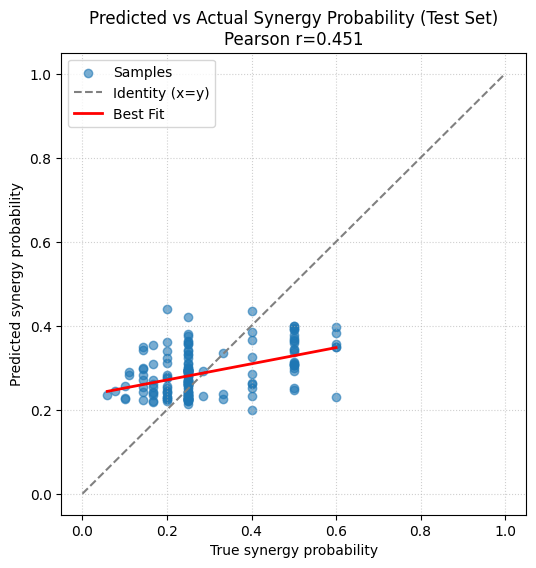

In [20]:
test_preds = get_predictions_synergy_model(model_loaded, test_loader, label_name='target_soft_smoothed', device=device)

preds = np.array(test_preds['preds'])
labels = np.array(test_preds['labels'])

pred_synergy = preds[:, 2]
label_synergy = labels[:, 2]

p_corr, _ = pearsonr(label_synergy, pred_synergy)

m, b = np.polyfit(label_synergy, pred_synergy, 1)
x_fit = np.linspace(label_synergy.min(), label_synergy.max(), 100)
y_fit = m * x_fit + b

plt.figure(figsize=(6, 6))
plt.scatter(label_synergy, pred_synergy, alpha=0.6, label='Samples')
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Identity (x=y)")
plt.plot(x_fit, y_fit, color="red", linestyle="-", linewidth=2, label=f"Best Fit")
plt.xlabel("True synergy probability")
plt.ylabel("Predicted synergy probability")
plt.title(f"Predicted vs Actual Synergy Probability (Test Set)\nPearson r={p_corr:.3f}")
plt.legend()
plt.grid(True, linestyle=':', alpha=0.6)
plt.show()